# LLaDA Benchmark Playground

이 노트북은 **정량적 평가**를 위한 벤치마크 실험을 수행합니다.

## 목적
- Academic Benchmarks (GSM8K, MMLU)를 사용한 A/B 테스트
- Baseline vs Experimental 샘플링 전략 비교
- 메트릭: Accuracy, Perplexity, Stability, Survival Rate, Correction Efficacy

In [1]:
import os
import sys
import torch
import pandas as pd
from transformers import AutoTokenizer

# Add current directory to path
current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.append(current_dir)

# Import local modules
from modeling_llada import LLaDAModelLM
from configuration_llada import LLaDAConfig
import experiment_utils
import decoding
from tta_uncertainty_sampling import generate_with_tta_uncertainty

print("Modules loaded successfully.")

Modules loaded successfully.


## 1. Load Model

In [2]:
LOCAL_MODEL_PATH = "../Grok-1-LLaDA-8B"
HF_MODEL_ID = "GSAI-ML/LLaDA-8B-Base"

model_path = HF_MODEL_ID
if os.path.exists(LOCAL_MODEL_PATH):
    model_path = LOCAL_MODEL_PATH
    print(f"Using local model: {model_path}")
else:
    print(f"Using HuggingFace model: {model_path}")

config = LLaDAConfig.from_pretrained(model_path)
model = LLaDAModelLM.from_pretrained(model_path, config=config, torch_dtype="auto")

if torch.cuda.is_available():
    model.cuda()
model.eval()

tokenizer = AutoTokenizer.from_pretrained(model_path)
print("Model loaded successfully.")

Using HuggingFace model: GSAI-ML/LLaDA-8B-Base


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Model loaded successfully.


## 2. Run Academic Benchmark

이 셀은 GSM8K와 MMLU 데이터셋을 사용하여 **TTA Uncertainty Sampling**을 벤치마크합니다.

### 설정 옵션:
- **Temporal Decay 테스트**: `experimental_fn=None` (기본값)
- **TTA 테스트**: `experimental_fn=generate_with_tta_uncertainty` (현재 설정)

In [3]:
# Benchmark Configuration
TTA_K_VALUES = [3, 5, 7]  # TTA forward pass 횟수
N_SAMPLES = 20  # Number of samples per task (빠른 테스트용, 전체는 50)
STEPS = 32  # 빠른 테스트용 (전체는 64)
GEN_LENGTH = 32
BLOCK_LENGTH = 32

print(f"Starting TTA Uncertainty Sampling Benchmark")
print(f"TTA K Values: {TTA_K_VALUES}")
print(f"Samples per task: {N_SAMPLES}")
print(f"Expected time: ~{N_SAMPLES * len(TTA_K_VALUES) * 2} minutes")

results_df = experiment_utils.run_academic_benchmark(
    model=model,
    tokenizer=tokenizer,
    baseline_fn=None,  # Uses inspect_sampling (no remasking)
    experimental_fn=generate_with_tta_uncertainty,  # TTA algorithm
    thresholds=TTA_K_VALUES,  # Different tta_k values to test
    samples=N_SAMPLES,
    steps=STEPS,
    gen_length=GEN_LENGTH,
    block_length=BLOCK_LENGTH
)

print("\nBenchmark completed!")
print(f"Total results: {len(results_df)} rows")

Starting TTA Uncertainty Sampling Benchmark
TTA K Values: [3, 5, 7]
Samples per task: 20
Expected time: ~120 minutes
Loading Academic Benchmarks (N=20 per task)...
Loaded 38 total samples.
Progress: [10/114] - Testing alpha_decay=3
Progress: [20/114] - Testing alpha_decay=5
Progress: [30/114] - Testing alpha_decay=7
Progress: [40/114] - Testing alpha_decay=3
Progress: [50/114] - Testing alpha_decay=5
Progress: [60/114] - Testing alpha_decay=7
Progress: [70/114] - Testing alpha_decay=3
Progress: [80/114] - Testing alpha_decay=5
Progress: [90/114] - Testing alpha_decay=7
Progress: [100/114] - Testing alpha_decay=3
Progress: [110/114] - Testing alpha_decay=5

Benchmark completed!
Total results: 114 rows


## 3. Analyze Results

\n===== ICML Benchmark Results =====


Acc_Base   Acc_Exp  Acc_Delta  \
Category                  AlphaDecay                                  
Logic (formal_logic)      3           0.500000  0.000000       -0.5   
                          5           0.500000  0.000000       -0.5   
                          7           0.500000  0.000000       -0.5   
Logic (logical_fallacies) 3           1.000000  0.000000       -1.0   
                          5           1.000000  0.000000       -1.0   
                          7           1.000000  0.000000       -1.0   
Logic (philosophy)        3           0.333333  0.333333        0.0   
                          5           0.333333  0.333333        0.0   
                          7           0.333333  0.333333        0.0   
Math (GSM8K)              3           0.000000  0.000000        0.0   
                          5           0.000000  0.000000        0.0   
                          7           0.000000  0.000000        0.0   

                                      PPL_Delta  Stability_Delta  
Category                  AlphaDecay                              
Logic (formal_logic)      3           -0.029948         0.041420  
                          5           -0.029948         0.041420  
                          7           -0.029948         0.041420  
Logic (logical_fallacies) 3           -0.065104         0.073766  
                          5           -0.065104         0.073766  
                          7           -0.065104         0.073766  
Logic (philosophy)        3            0.045573         0.082289  
                          5            0.045573         0.082289  
                          7            0.045573         0.082289  
Math (GSM8K)              3            0.039844         0.071821  
                          5            0.039844         0.071821  
                          7            0.039844         0.071821

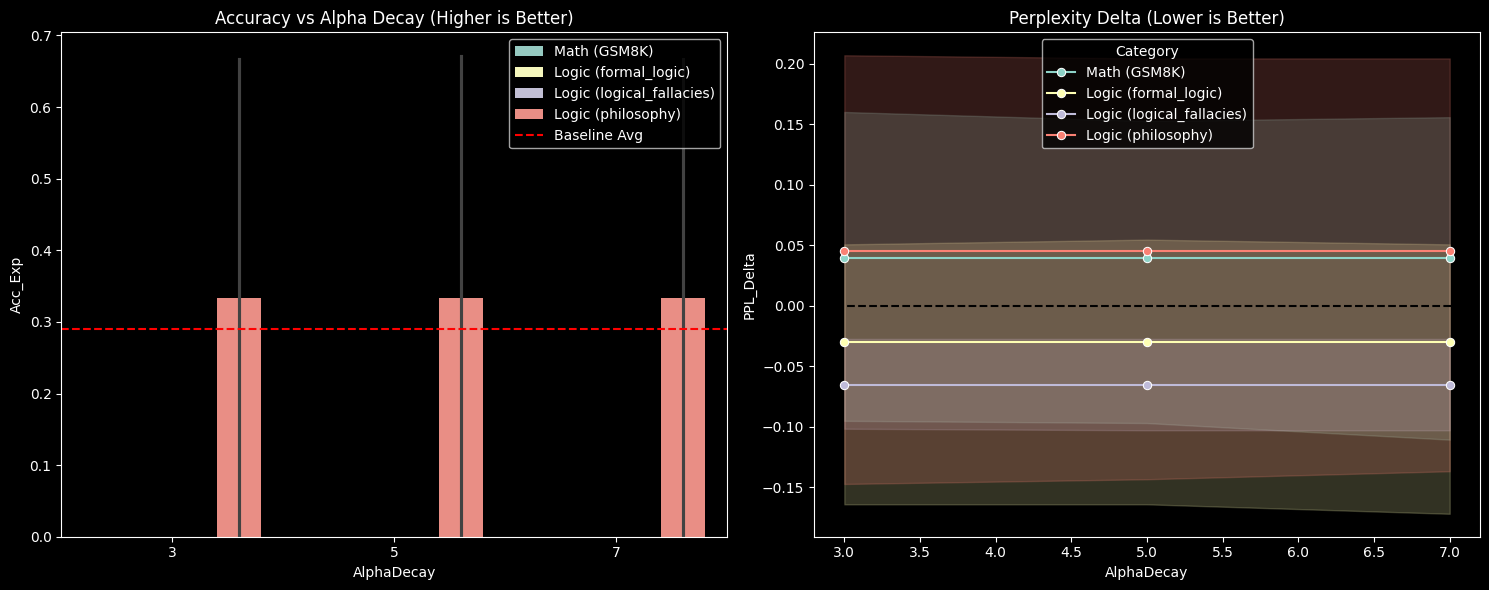

\n[Key Findings]
Best Alpha Decay: 3
Optimal Accuracy: 5.26%
Baseline Accuracy: 28.95%
Improvement: -23.68%


In [4]:
# Display comprehensive analysis
experiment_utils.analyze_icml_results(results_df)

## 4. Save Results

In [5]:
# Save to CSV for further analysis
output_file = "tta_benchmark_results.csv"
results_df.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")

Results saved to tta_benchmark_results.csv


## 5. Detailed Inspection (Optional)

특정 케이스를 자세히 살펴보고 싶다면 아래 셀을 사용하세요.

In [6]:
# Filter for specific category or AlphaDecay (TTA K)
print("\n=== Math Task Results ===")
math_results = results_df[results_df['Category'] == 'math']
print(math_results.groupby('AlphaDecay')[['Acc_Exp', 'PPL_Delta', 'Stability_Delta']].mean())

print("\n=== Logic Task Results ===")
logic_results = results_df[results_df['Category'] == 'logic']
print(logic_results.groupby('AlphaDecay')[['Acc_Exp', 'PPL_Delta', 'Stability_Delta']].mean())


=== Math Task Results ===
Empty DataFrame
Columns: [Acc_Exp, PPL_Delta, Stability_Delta]
Index: []

=== Logic Task Results ===
Empty DataFrame
Columns: [Acc_Exp, PPL_Delta, Stability_Delta]
Index: []


## 6. TTA-Specific Analysis

TTA 알고리즘의 불확실성 메트릭을 분석합니다.

In [7]:
# Summary by TTA K
print("\n=== Performance by TTA K ===")
summary = results_df.groupby('AlphaDecay')[['Acc_Exp', 'PPL_Delta', 'Stability_Delta', 'Survival', 'Correction_Eff']].mean()
print(summary)

# Best configuration
best_k = summary['Acc_Exp'].idxmax()
best_acc = summary['Acc_Exp'].max()
baseline_acc = results_df['Acc_Base'].mean()

print(f"\n=== Best Configuration ===")
print(f"Best TTA K: {best_k}")
print(f"Accuracy: {best_acc:.2%} (Baseline: {baseline_acc:.2%})")
print(f"Improvement: {best_acc - baseline_acc:+.2%}")


=== Performance by TTA K ===
             Acc_Exp  PPL_Delta  Stability_Delta  Survival  Correction_Eff
AlphaDecay                                                                
3           0.052632   0.013158         0.068981       0.0         0.03125
5           0.052632   0.013158         0.068981       0.0         0.03125
7           0.052632   0.013158         0.068981       0.0         0.03125

=== Best Configuration ===
Best TTA K: 3
Accuracy: 5.26% (Baseline: 28.95%)
Improvement: -23.68%
